In [1]:
import warnings

import numpy as np
import pandas as pd
import torch
from torch import device, cuda, autocast
from torch.cuda.amp import GradScaler
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import wandb
from conv_models import RawImagesCNN
from from_video_to_training_batched_funcs import get_files_from_directory, select_random_videos, paths_to_labels, load_custom_sequences
from logs_to_wandb import log_original_to_wandb
from utils import plot_weber_fraction

warnings.filterwarnings(
    'ignore',
    message='invalid value encountered in cast',
    category=RuntimeWarning,
    module='wandb.sdk.data_types.image'
)

device_type = "cuda" if cuda.is_available() else "cpu"
DEVICE = device(device_type)
torch.manual_seed(42)
batch_size = 50
last_good_frame = 2

TRAINING_DATA_DIR = "easy_videos"
TESTING_DATA_DIR = "easyval_videos"

debugging = False
debug_length = 50
wandb_ = True
wandb_images_every = 10

num_epochs = 1

channel_sizes = [16, 32, 64]
mult_size = 1
channel_sizes = [int(a * mult_size) for a in channel_sizes]
dropout = .5

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
all_videos = get_files_from_directory(TRAINING_DATA_DIR)
all_validation_videos = get_files_from_directory(TESTING_DATA_DIR)

In [3]:
model = RawImagesCNN(
    out_channels_1 = channel_sizes[0],
    out_channels_2 = channel_sizes[1],
    out_channels_3 = channel_sizes[2],
    dropout = dropout
).to(DEVICE)
lr = .01
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
scaler = GradScaler()

# Initialize the loss function
criterion = BCEWithLogitsLoss()

In [4]:
model.train()

iterations = debug_length if debugging else len(all_videos) // batch_size
# Start wandb run
if wandb_:
    wandb.init(project='binary_classification')
    data_table = wandb.Table(columns=["Predictions", "True Labels"])

# Training loop
for epoch in range(num_epochs):
    already_selected = []
    running_loss = 0.0
    correct = 0
    total = 0
    for i in tqdm(range(iterations)):
        batch_files, already_selected = select_random_videos(
            all_videos, batch_size, already_selected
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = load_custom_sequences(batch_files)
        batch_sequences = batch_sequences[:, -last_good_frame, :, :] 
        if wandb_ and i % wandb_images_every == 0:
            log_original_to_wandb(batch_sequences[0], batch_files[0])
        
        # Add channel dimension and normalize
        batch_sequences = np.divide(batch_sequences[:, None, :, :], 255)

        # Ensure the data is in tensor form and on the correct device
        labels_tensor = torch.tensor(labels, dtype=torch.float).to(DEVICE)
        batch_sequences_tensor = torch.tensor(batch_sequences, dtype=torch.float).to(DEVICE)

        # Create the dataset and dataloader
        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs.to(DEVICE)
            batch_labels.to(DEVICE)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
    
            # Forward pass
            with autocast(device_type):
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), batch_labels)
    
            # Backward pass and optimize
                loss.backward()
                optimizer.step()
    
                # Calculate the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                predictions = torch.sigmoid(outputs).squeeze() > 0.5
                total += batch_labels.size(0)
                correct += (predictions == batch_labels).sum().item()
                
                if wandb_:
                    predictions = torch.sigmoid(outputs).squeeze().detach().cpu()
                    batch_labels_cpu = batch_labels.detach().cpu()
                    for pred, label in zip(predictions, batch_labels_cpu):
                        data_table.add_data(pred.item(), label.item())

        # Log metrics to wandb
        if wandb_:
            wandb.log({
                'epoch': epoch,
                'loss': running_loss / total,
                'accuracy': correct / total,
            })
    wandb.log({"predictions_vs_labels": data_table})

    print(f'Epoch {epoch+1}, Loss: {running_loss / total}, Accuracy: {correct / total}')

wandb: Currently logged in as: eudald. Use `wandb login --relogin` to force relogin


100%|██████████| 336/336 [30:20<00:00,  5.42s/it]


Epoch 1, Loss: 0.3320864013706644, Accuracy: 0.9113690476190476


In [7]:
model.eval() 

total_correct = 0
total = 0
running_loss = 0.0

validation_results = pd.DataFrame(columns=["Image", "Prediction", "True Label"])
with torch.no_grad():  # Disable gradient calculation
    for i in tqdm(range(len(all_validation_videos) // batch_size)):
        batch_files, _ = select_random_videos(
            all_validation_videos, batch_size, already_selected=[]
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = load_custom_sequences(batch_files)
        batch_sequences = batch_sequences[:, -last_good_frame, :, :]
        batch_sequences = np.divide(batch_sequences[:, None, :, :], 255)

        labels_tensor = torch.tensor(labels, dtype=torch.float).to(DEVICE)
        batch_sequences_tensor = torch.tensor(batch_sequences, dtype=torch.float).to(DEVICE)

        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs, batch_labels = inputs.to(DEVICE), batch_labels.to(DEVICE)
            
            # Forward pass only to get logits/output
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), batch_labels)

            running_loss += loss.item() * inputs.size(0)
            predictions = torch.round(torch.sigmoid(outputs).squeeze()).cpu().numpy()
            correct = np.where(predictions == batch_labels.cpu().numpy(), 1, 0)
            total += batch_labels.size(0)
            total_correct += correct.sum().item()
            
            validation_results = pd.concat(
                [validation_results, pd.DataFrame({
                    "Image": batch_files,
                    "Prediction": predictions.squeeze().tolist(),
                    "True label": batch_labels.tolist(),
                    "Is correct": correct.tolist()
        })]
            )
            
print(f'Validation Loss: {running_loss / total}, '
      f'Validation Accuracy: {total_correct / total}')


100%|██████████| 78/78 [05:04<00:00,  3.90s/it]

Validation Loss: 51.589053569695885, Validation Accuracy: 0.5028205128205128


accuracy,▁▂▂▃▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,██▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁
val_loss,▁
accuracy,0.91137
epoch,0
loss,0.33209
val_accuracy,0.50282
val_loss,51.58905


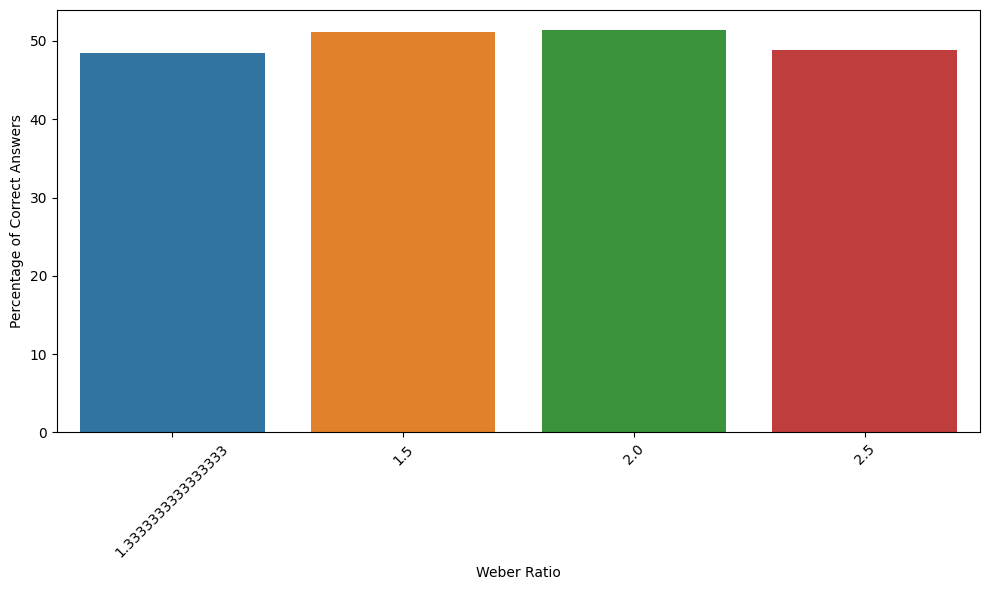

In [8]:
weber_plot = plot_weber_fraction(validation_results)

# Log validation metrics to wandb
if wandb_:
    wandb.log({
        'val_loss': running_loss / total,
        'val_accuracy': total_correct / total,
        "validation_results": wandb.Table(dataframe=validation_results),
        "Weber Fraction Plot": wandb.Image(weber_plot)
    })
    wandb.finish()
